In [8]:
pip install mesa

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade pip

In [3]:
#Import

#Modelling

import mesa

from mesa import Agent, Model

import solara

#Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

from mesa.experimental import JupyterViz

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import pandas as pd

import random

In [4]:
from typing import Callable, Optional, Type

class RandomActivationByTypeFiltered(mesa.time.RandomActivationByType):
    """
    A scheduler that overrides the get_type_count method to allow for filtering
    of agents by a function before counting.

    Example:
    >>> scheduler = RandomActivationByTypeFiltered(model)
    >>> scheduler.get_type_count(AgentA, lambda agent: agent.some_attribute > 10)
    """

    def get_type_count(
        self,
        type_class: Type[mesa.Agent],
        filter_func: Optional[Callable[[mesa.Agent], bool]] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue
        that satisfy the filter function.
        """
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

In [5]:
#Model

class BrainModel(Model):
    def __init__(self, Nn, Na, width, height):
        super().__init__()
        self.num_neurons = Nn
        self.num_antibody = Na
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivationByTypeFiltered(self)
        self.running = True
        self.step_count = 0
        self.datacollector = DataCollector(
            model_reporters={
            "Total surface NMDARs": compute_tot_nmdar,
            "Number of Antibodies": lambda m: m.schedule.get_type_count(AntibAgent)   
        },
        agent_reporters={
            "Surface NMDAR Conc.": "NMDAR",
            "Agent type": "type"
        }, 
    )
        
    # Create Neurons
        for unique_id in range(self.num_neurons):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            neuron = NeuronAgent(unique_id, self)
            self.grid.place_agent(neuron, (x, y))
            self.schedule.add(neuron)

    #Create Antibodies
        for i in range(self.num_antibody):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            antib = AntibAgent((i,x,y), self)
            self.grid.place_agent(antib, (x, y))
            self.schedule.add(antib) 

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.step_count += 1

        for agent in self.schedule.agents[:]:
            if hasattr(agent, "remove"):
                agent.remove()


#Agents

class NeuronAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.NMDAR = 1.2e12
        self.type = "Neuron" 

    def step(self):
        if self.model.step_count % random.randint(50,144) == 0 and self.NMDAR < 1.2e12:
            self.NMDAR += random.randint(0,1)

class AntibAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.NMDAR = 0
        self.type = "Antibody"
        self.energy = 1200     
        self.marked_for_removal = False    

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        
        if possible_steps:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
            self.pos = new_position

    def step(self):
        self.move()
        self.energy -= random.randint(0,2)

        #if there is a neuron nearby, internalise NMDAR
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        neuron = [obj for obj in this_cell if isinstance(obj, NeuronAgent)]
        if neuron:
             affected_neuron = self.random.choice(neuron)

             # Internalise NMDAR, along with itself
             affected_neuron.NMDAR -= 1

             self.marked_for_removal = True
        
        #Death from time
        if self.energy <= 0:
            self.marked_for_removal = True

    def remove(self):
        if self.marked_for_removal:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)


def compute_tot_nmdar(model):
    
    agent_nmdars =  [agent.NMDAR for agent in model.schedule.agents]

    tot = sum(agent_nmdars)

    return tot    


In [41]:
model = BrainModel(100, 40000, 1000, 1000)

for i in range(1000):
    model.step()

In [42]:
agent_df = model.datacollector.get_agent_vars_dataframe()
model_df = model.datacollector.get_model_vars_dataframe()

model_df


,Total surface NMDARs,Number of Antibodies
0,1.200000e+14,40000
1,1.200000e+14,39995
2,1.200000e+14,39990
3,1.200000e+14,39989
4,1.200000e+14,39988
...,...,...
995,1.200000e+14,38186
996,1.200000e+14,38180
997,1.200000e+14,38179
998,1.200000e+14,38176


119999999998723.0
38173


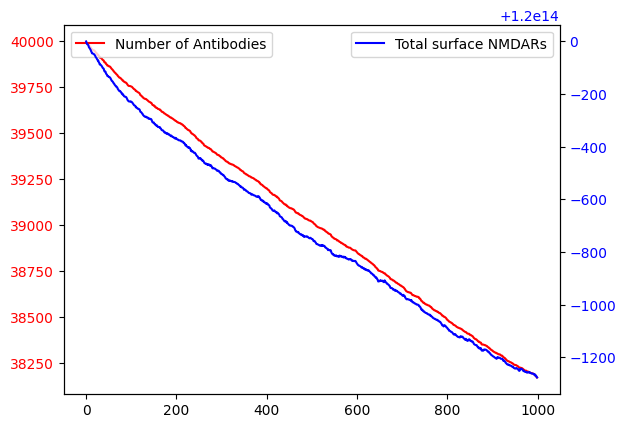

In [43]:
%matplotlib inline

print(model_df['Total surface NMDARs'].min())
print(model_df['Number of Antibodies'].min())

fig, ax = plt.subplots()


ax.plot(model_df['Number of Antibodies'], label = 'Number of Antibodies', color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()

ax2.plot(model_df['Total surface NMDARs'], label = 'Total surface NMDARs', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')


plt.show()

In [44]:
neuron_df = agent_df.loc[agent_df['Agent type'] == 'Neuron']

neuron_df

Surface NMDAR Conc. Agent type
Step AgentID                                
0    0               1.200000e+12     Neuron
     1               1.200000e+12     Neuron
     2               1.200000e+12     Neuron
     3               1.200000e+12     Neuron
     4               1.200000e+12     Neuron
...                           ...        ...
999  95              1.200000e+12     Neuron
     96              1.200000e+12     Neuron
     97              1.200000e+12     Neuron
     98              1.200000e+12     Neuron
     99              1.200000e+12     Neuron

[100000 rows x 2 columns]

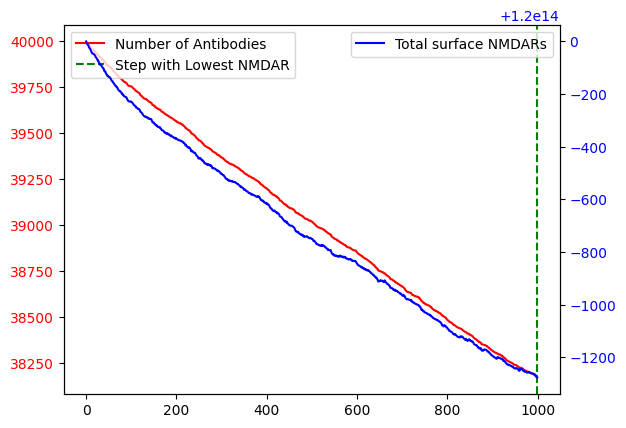

Step with lowest NMDAR concentration: 999


In [45]:
import matplotlib.pyplot as plt

# ... (previous code)

# Add this code after your existing code

# Find the step with the lowest concentration surface NMDAR
min_step = model_df['Total surface NMDARs'].idxmin()

# Plot the result
fig, ax = plt.subplots()
ax.plot(model_df['Number of Antibodies'], label='Number of Antibodies', color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(model_df['Total surface NMDARs'], label='Total surface NMDARs', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=min_step, color='green', linestyle='--', label='Step with Lowest NMDAR')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Print the step with the lowest concentration surface NMDAR
print("Step with lowest NMDAR concentration:", min_step)


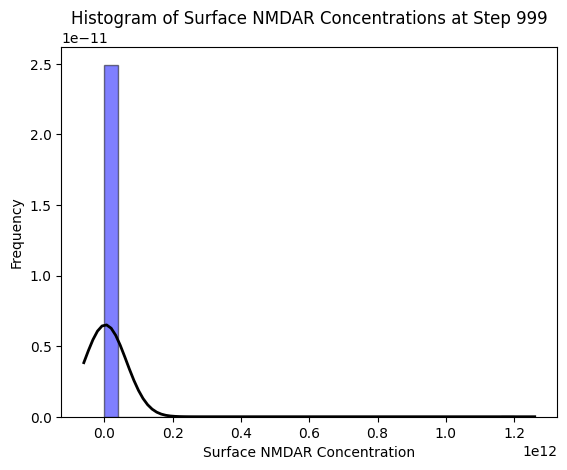

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Extract surface NMDAR concentrations at the step with the lowest concentration
nmdar_data = agent_df.loc[(min_step, slice(None)), 'Surface NMDAR Conc.']

# Create a histogram
plt.hist(nmdar_data, bins=30, density=True, alpha=0.5, color='b', edgecolor='black')

# Add a normal distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mean = np.mean(nmdar_data)
std_dev = np.std(nmdar_data)
pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
plt.plot(x, pdf, 'k', linewidth=2)

# Mark and display the plot
plt.title('Histogram of Surface NMDAR Concentrations at Step {}'.format(min_step))
plt.xlabel('Surface NMDAR Concentration')
plt.ylabel('Frequency')
plt.show()


In [50]:
"""
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "blue",
                 "r": 0.5}
    
    if isinstance(agent, AntibAgent):
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2

    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 100, 100, 500, 500)

nmdar = mesa.visualization.ChartModule([{"Label": "Total surface NMDARs", "Color": "Red"}],
                                       data_collector_name='datacollector')

ab = mesa.visualization.ChartModule([{"Label": "Number of Antibodies", "Color": "Blue"}],
                                       data_collector_name='datacollector')


server = mesa.visualization.ModularServer(
    BrainModel, 
    [grid, nmdar, ab], 
    "Brain Model", 
    {"Nn":1000, "Na":500, "width":1000, "height":1000,}
)

server.port = 8521
server.launch()
"""

'\ndef agent_portrayal(agent):\n    portrayal = {"Shape": "circle",\n                 "Filled": "true",\n                 "Layer": 0,\n                 "Color": "blue",\n                 "r": 0.5}\n    \n    if isinstance(agent, AntibAgent):\n        portrayal["Color"] = "red"\n        portrayal["Layer"] = 1\n        portrayal["r"] = 0.2\n\n    return portrayal\n\ngrid = mesa.visualization.CanvasGrid(agent_portrayal, 100, 100, 500, 500)\n\nnmdar = mesa.visualization.ChartModule([{"Label": "Total surface NMDARs", "Color": "Red"}],\n                                       data_collector_name=\'datacollector\')\n\nab = mesa.visualization.ChartModule([{"Label": "Number of Antibodies", "Color": "Blue"}],\n                                       data_collector_name=\'datacollector\')\n\n\nserver = mesa.visualization.ModularServer(\n    BrainModel, \n    [grid, nmdar, ab], \n    "Brain Model", \n    {"Nn":1000, "Na":500, "width":1000, "height":1000,}\n)\n\nserver.port = 8521\nserver.launch()\n'